In [1]:
# load needed modules
import numba 
import numpy as np

import time

import numpy as np
from numba import cuda
from math import ceil 

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#print out gpu information

gpu = numba.cuda.get_current_device()
print("name = %s" % gpu.name)
print("maxThreadsPerBlock = %s" % str(gpu.MAX_THREADS_PER_BLOCK))
print("maxBlockDimX = %s" % str(gpu.MAX_BLOCK_DIM_X))
print("maxBlockDimY = %s" % str(gpu.MAX_BLOCK_DIM_Y))
print("maxBlockDimZ = %s" % str(gpu.MAX_BLOCK_DIM_Z))
print("maxGridDimX = %s" % str(gpu.MAX_GRID_DIM_X))
print("maxGridDimY = %s" % str(gpu.MAX_GRID_DIM_Y))
print("maxGridDimZ = %s" % str(gpu.MAX_GRID_DIM_Z))
print("maxSharedMemoryPerBlock = %s" % str(gpu.MAX_SHARED_MEMORY_PER_BLOCK))
print("asyncEngineCount = %s" % str(gpu.ASYNC_ENGINE_COUNT))
print("canMapHostMemory = %s" % str(gpu.CAN_MAP_HOST_MEMORY))
print("multiProcessorCount = %s" % str(gpu.MULTIPROCESSOR_COUNT))
print("warpSize = %s" % str(gpu.WARP_SIZE))
print("unifiedAddressing = %s" % str(gpu.UNIFIED_ADDRESSING))
print("pciBusID = %s" % str(gpu.PCI_BUS_ID))
print("pciDeviceID = %s" % str(gpu.PCI_DEVICE_ID))

CudaSupportError: Error at driver init: 
[803] Call to cuInit results in UNKNOWN_CUDA_ERROR:

In [3]:
#generate dummy data for test

Nz, Ny, Nx = 128, 512, 128

real_data = (np.ones((Nz, Ny, Nx)) * np.sin(np.linspace(0, 20, Ny)[np.newaxis, :, np.newaxis])*0.5 
             + np.random.normal(scale=1.0, size=(Nz, Ny, Nx)) )

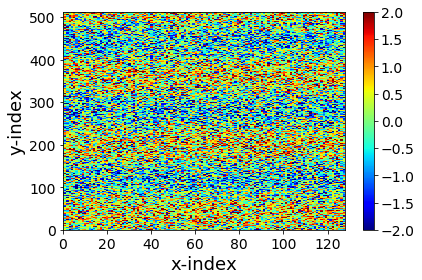

In [4]:
#visulize date: before filtering:

plt.pcolormesh(real_data[Nz//2,:, :], vmin=-2, vmax=2, cmap=plt.cm.jet)

cb = plt.colorbar()
for i in cb.ax.get_yticklabels():
    i.set_fontsize(14)
    
plt.xlabel("x-index", fontsize=18)
plt.xticks( fontsize=14)
plt.ylabel("y-index", fontsize=18)
plt.yticks( fontsize=14)

plt.tight_layout()

plt.show()

In [5]:
# define the output result: same size of input data
output_data = real_data.copy()

#define the stencil size (3D)
stencil = (2, 1, 2)

In [6]:
# ================================= median ================================== #

'''
 @param:
     - input_data:  np.array, 3D data to filter
     - output_data: np.array, 3D data after filtering,same size of input (because cuda kernel function can't return value)
     - fkt:         function, numba_median, numba_avgerage, ... (what else?) ==> Gaussian?
     - stencil:     tuple of size 3, the dimension of 3D stencil 
     
 @function: 
     stencil filter on GPU, reference: https://en.wikipedia.org/wiki/Stencil_code
'''

# tile size?


@cuda.jit
def gpu_smooth_kernel_naive(input_data, output_data, stencil_z, stencil_y, stencil_x, Nz, Ny, Nx):
    
    
    # ==== stencil size ==== #
    #dx = stencil_[0] dosen't work, compile issue
    #dy = stencil_[1]
    #dz = stencil_[2]
    dx = stencil_x * 2 + 1
    dy = stencil_y * 2 + 1
    dz = stencil_z * 2 + 1
    # ====================== #
 
    # ==== global thread index ==== #
    row_global = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x;
    col_global = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y;
    depth_global = cuda.threadIdx.z + cuda.blockIdx.z * cuda.blockDim.z;

    # ============================= # 
    
    # ==== shared mem. ==== #   
    times = 64 # now every thread only loads at most 2 times to mem.
    tile_size_z = dz * times #64 * 5 = 320
    tile_size_y = dy * times #64 * 3 = 192
    tile_size_x = dx * times #64 * 5 = 320
    
    shared_mem_size_z = tile_size_z + stencil_z * 2 #  stencil_z * 2: including apron 
    shared_mem_size_y = tile_size_y + stencil_y * 2
    shared_mem_size_x = tile_size_x + stencil_x * 2
       
    shared_mem = cuda.shared.array(shape=(shared_mem_size_z, shared_mem_size_y, shared_mem_size_x), dtype=float32) 
    # maybe compile issue: https://stackoverflow.com/questions/30510580/numba-cuda-shared-memory-size-at-runtime 
    
    
    # grid stride:
    while(depth_global < Nz):
        z_min = max(depth_global - stencil_z, 0)
        z_max = min(depth_global + stencil_z + 1, Nz)
        while(col_global < Ny):
            y_min = max(col_global - stencil_y, 0)
            y_max = min(col_global + stencil_y + 1, Ny)
            while(row_global < Nx):
                x_min = max(row_global - stencil_x, 0)
                x_max = min(row_global + stencil_x + 1, Nx)
                
                # split the block into tiles
                # Preload data into shared memory
                # PS. different bounding method also influences. ===========> modify it when use other bounding method case   
                            
                # split the tiles into filters: 1 tile has times(10) filters
                # 2-steps load data:
                # https://www.evl.uic.edu/sjames/cs525/final.html
                # 1. 
                dest = cuda.threadIdx.x + (cuda.threadIdx.y * tile_size_x) + (cuda.threadIdx.z * tile_size_y * tile_size_x)
                destTmp = dest
                destX = destTmp % shared_mem_size_x
                destTmp = int(destTmp / shared_mem_size_x)
                destY = destTmp % shared_mem_size_y
                destTmp = int(destTmp / shared_mem_size_y);
                destZ = destTmp
                # for example: tile_size_x = 12, tile_size_y = 14, tile_size_x = 16
                # dest = x + 12 * y + 12 * 14 * z
                # how to get x, y, z? ==> mod and /
                
                srcZ = (blockIdx.z * tile_size_z) + destZ - stencil_z;
                srcY = (blockIdx.y * tile_size_y) + destY - stencil_y;
                srcX = (blockIdx.x * tile_size_x) + destX - stencil_x;
                
                if(srcZ >= 0 && srcZ < Nz && srcY >= 0 && srcY < Ny && srcX >= 0 && srcX < Nx):
                    shared_mem[destZ, destY, destX] = input_data[srcZ, srcY, srcX]
                else:
                    shared_mem[destZ, destY, destX] = 0

                # 2.    
                dest = cuda.threadIdx.x + (cuda.threadIdx.y * tile_size_x) + (cuda.threadIdx.z * tile_size_y * tile_size_x)  \
                         + tile_size_x * tile_size_y * tile_size_z;
                
                destTmp = dest
                destX = destTmp % shared_mem_size_x
                destTmp = int(destTmp / shared_mem_size_x)
                destY = destTmp % shared_mem_size_y
                destTmp = int(destTmp / shared_mem_size_y);
                destZ = destTmp
                
                srcZ = (cuda.blockIdx.z * tile_size_z) + destZ - stencil_z;
                srcY = (cuda.blockIdx.y * tile_size_y) + destY - stencil_y;
                srcX = (cuda.blockIdx.x * tile_size_x) + destX - stencil_x;
                if(destZ < shared_mem_size_z):
                    if(srcZ >= 0 && srcZ < depth && srcY >= 0 && srcY < height && srcX >= 0 && srcX < width):
                        shared_mem[destZ, destY, destX] = input_data[srcZ, srcY, srcX]
                    else:
                        shared_mem[destZ, destY, destX] = 0                              
                cuda.syncthreads()
                
                # now let's try to calculate mean value
                sum = 0
                for z in range(dz):
                    for y in range(dy):
                        for x in range(dx):
                            sum = sum + shared_mem[threadIdx.z + z][threadIdx.y + y][threadIdx.x + x]
                mean = sum / (0.0 + ((z_max - z_min) * (y_max - y_min) * (x_max - x_min)))
                # here ignore bounding pixel
                
                out_z = cuda.threadIdx.z + cuda.blockIdx.z * tile_size_z
                out_y = cuda.threadIdx.y + cuda.blockIdx.y * tile_size_y
                out_x = cuda.threadIdx.x + cuda.blockIdx.x * tile_size_x
                if(out_z < Ny && out_y < Ny && out_x < Nx):
                    output[out_x, out_y, out_z] = mean
                cuda.syncthreads()

                
                row_global += cuda.blockDim.x * cuda.gridDim.x
            col_global += cuda.blockDim.y * cuda.gridDim.y
        depth_global += cuda.blockDim.z * cuda.gridDim.z
 
 
        
def lauch_kernel(input_data, output_data, stencil_):
    # TODO: set blocksize, gridsize and lauch kernel
    # define threads and blocks
    # threads = 128
    # blocks = 2048/threads * 13 
    # if we want to use shared mem.
    # then the tile_size must be == block_size
    threads_z = 5 * 64
    threads_y = 3 * 64
    threads_x = 5 * 64
    blocks = 13 
    # TODO: tune this parameter
    
    print("==================")
    print("threads_z: " + str(threads_z))
    print("threads_y: " + str(threads_y))
    print("threads_x: " + str(threads_x))
    
    print("blocks: " + str(blocks))
    print("==================")
    
    Nz, Ny, Nx = np.shape(input_data) # why here z, y, x ?
    stencil_z, stencil_y, stencil_x = stencil_[0], stencil_[1], stencil_[2]
    start = time.time()
    # call CUDA kernel
    gpu_smooth_kernel_naive[(threads_x, threads_y, threads_z), (int(blocks), 1, 1)](input_data, output_data,stencil_z, stencil_y, stencil_x, Nz, Ny, Nx)
   
    #gpu_smooth_kernel_naive[(1,1,1), (1,1,1)](input_data, output_data,stencil_z, stencil_y, stencil_x, Nz, Ny, Nx)
    #Elapsed (gpu naive with compilation) = 0.8788273334503174
    #Elapsed (gpu naive without compilation) = 0.039675235748291016
    
    end = time.time()
    print("Elapsed (gpu naive with compilation) = %s" % (end - start))

    start = time.time()
    gpu_smooth_kernel_naive[(threads_x, threads_y, threads_z), (int(blocks), 1, 1)](input_data, output_data,stencil_z, stencil_y, stencil_x, Nz, Ny, Nx)
    end = time.time()
    print("Elapsed (gpu naive without compilation) = %s" % (end - start))


In [7]:
stencil_t = np.array([1, 2, 1])
lauch_kernel(real_data, output_data, stencil_t)


threads: 128
blocks: 208.0
Elapsed (gpu naive with compilation) = 0.8215947151184082
Elapsed (gpu naive without compilation) = 0.04338645935058594
